In [1]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64, prange
import numba
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix

from qutip import sigmax, sigmay, sigmaz, jmat

import time

from labellines import labelLine, labelLines

In [2]:
# Coupling formula
mu_0 = 12.5663706127e-7 # r^3/T^2/J
h = 6.62607015e-34 # J/s
gamma_w = 1.1282407e7 * h/2/np.pi # J/T
alpha_w = mu_0/4/np.pi * (gamma_w)**2 # J.r^3
gamma_ratio = 1.1282407/6.567400
gamma_nb = gamma_w / gamma_ratio # J/T

mu_B = 9.2740094980e-24 # J/T
erbium_gamma = -mu_B * np.array((8.38,8.38, 1.247)) # J/T

# https://doi.org/10.1063/1.1725143
a = 5.243e-10 # In meters
c = 11.376e-10 # In meters
# Lattice parameters:
lattice_x = np.array([a, 0, 0])
lattice_y = np.array([0, a, 0])
lattice_z = np.array([0, 0, c])


omega_I = 799.531e3 * 2 * np.pi
omega_S = 7_741_655_681 * 2 * np.pi

lattice_s = np.array([[a, a, c]]) * np.array([
    [0.5,0.5,0],
    [0.5,0,0.25],
    [0,0,0.5],
    [0,0.5,0.75],
])

site_nb = lattice_s.shape[0]

In [3]:
def get_full_H_matrices(spin, pre_dim, post_dim):
    """
    Construct full spin operator matrices (Sx, Sy, Sz) embedded in a larger Hilbert space.

    This function generates the spin operators Sx, Sy, and Sz for a given spin value,
    and embeds them into a larger Hilbert space. The embedding 
    places the spin operator between identity matrices of dimension `pre_dim` and `post_dim`, 
    representing dimensions before and after the target spin in a composite system.

    Parameters
    ----------
    spin : float or int
        Spin value of the particle (e.g., 0.5 for spin-1/2, 1 for spin-1).
    
    pre_dim : int
        Dimension of the Hilbert space before the spin operator (e.g., for preceding spins).
    
    post_dim : int
        Dimension of the Hilbert space after the spin operator (e.g., for succeeding spins).

    Returns
    -------
    np.ndarray
        A NumPy array containing the full spin operator matrices [Sx, Sy, Sz], each of shape 
        (`pre_dim` * dim_spin * `post_dim`, `pre_dim` * dim_spin * `post_dim`), where `dim_spin = int(2 * spin + 1)`.
    """
    if pre_dim == 0:
        pre_dim = 1
    if post_dim == 0:
        post_dim = 1
    eye_pre = np.eye(pre_dim)
    eye_post = np.eye(post_dim)
    Ix = jmat(spin, 'x').full()
    Iy = jmat(spin, 'y').full()
    Iz = jmat(spin, 'z').full()
    Sx = np.kron(np.kron(eye_pre, Ix), eye_post)
    Sy = np.kron(np.kron(eye_pre, Iy), eye_post)
    Sz = np.kron(np.kron(eye_pre, Iz), eye_post)
    return np.array([Sx, Sy, Sz])

In [4]:
@jit
def dipolar_hamiltonian(mu_1, mu_2, xyz):
    """
    Computes the full dipole hamiltonian of two nuclear spins magnetic moment
    """
    r = np.linalg.norm(xyz)
    return mu_0/4/np.pi/r**3 * (
        # mu_1 . mu_2
        mu_1[0] @ mu_2[0]
        + mu_1[1] @ mu_2[1]
        + mu_1[2] @ mu_2[2]
        # -3/r² * (mu_1 . r) (mu_2 . r)
        -3/r**2 * (
            xyz[0]*mu_1[0]
            + xyz[1]*mu_1[1]
            + xyz[2]*mu_1[2]
        )
            @
            (
            xyz[0]*mu_2[0]
            + xyz[1]*mu_2[1]
            + xyz[2]*mu_2[2]
            )
        )

In [5]:
mu_S =  erbium_gamma[:,None, None] * get_full_H_matrices(1/2, 0, 4)
mu_I1 = gamma_w * get_full_H_matrices(1/2, 2, 2)
mu_I2 = gamma_w * get_full_H_matrices(1/2, 4, 0)

# Zeeman for each atom in the 8dim Hailtonian
H_zeeman_erbium = -h / 2 / np.pi * omega_S * mu_S[2]/erbium_gamma[2]
H_zeeman_I1 = -h / 2 / np.pi * omega_I * mu_I1[2] / gamma_w
H_zeeman_I2 = -h / 2 / np.pi * omega_I * mu_I2[2] / gamma_w

erbium_position = lattice_x * 0.5 + lattice_y * 0.5 + lattice_z * 0.5

@jit
def get_hamiltonian2(r1, r2):
    H_0 = (
        H_zeeman_erbium + H_zeeman_I1 + H_zeeman_I2
        + dipolar_hamiltonian(mu_I1, mu_I2, r1 - r2)
        + dipolar_hamiltonian(mu_I1, mu_S, r1 - erbium_position)
        + dipolar_hamiltonian(mu_I2, mu_S, r2 - erbium_position)
    )
    return H_0

@jit
def get_hamiltonian(r):
    H_0 = (
        H_zeeman_erbium + H_zeeman_I1
        + dipolar_hamiltonian(mu_I1, mu_S, r - erbium_position)
    )
    return H_0

In [6]:

@jit
def compute_coupling(vec1, vec2):
    r1 = lattice_x * vec1[0] + lattice_y * vec1[1] + lattice_z * vec1[2] + lattice_s[vec1[3]]
    r2 = lattice_x * vec2[0] + lattice_y * vec2[1] + lattice_z * vec2[2] + lattice_s[vec2[3]]

    H = get_hamiltonian2(r1, r2)

    eig, _ = np.linalg.eigh(H)
    return (eig[0] + eig[3] - eig[1] - eig[2])/h



@jit
def compute_a_par(vec1):
    r = lattice_x * vec1[0] + lattice_y * vec1[1] + lattice_z * vec1[2] + lattice_s[vec1[3]]

    H = get_hamiltonian(r)

    eig, _ = np.linalg.eigh(H)
    return (eig[0] + eig[1] + eig[7] + eig[6] - eig[2] - eig[4] - eig[3] - eig[5])/h/2

# State reconstruction

In [7]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
            index // (max_distance**2 * site_nb) - center,
            index // (max_distance * site_nb) % max_distance - center,
            index // site_nb % max_distance - center,
            index % site_nb
        )

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return (
                            (
                                (
                                    (vec[0] + center)*max_distance + (vec[1] + center)
                                )*max_distance
                                + (vec[2] + center)
                            )*site_nb
                            + vec[3]
                       
       )



@jit(parallel = True)
def get_all_couplings(max_distance, site_nb):
    couplings = np.empty((max_distance**3*site_nb, max_distance**3*site_nb))
    a_par = np.empty(max_distance**3*site_nb)
    for i in prange(max_distance**3*site_nb):
        couplings[i, i] = 0
        vec1 = index_to_coord(i, max_distance, site_nb)
        for j in prange(i+1, max_distance**3*site_nb):
            vec2 = index_to_coord(j, max_distance, site_nb)
            c = compute_coupling(vec1, vec2)
            couplings[i, j] = c
            couplings[j, i] = c
        a_par[i] = compute_a_par(vec1)
    return couplings, a_par

def vector_couplings(max_distance, site_nb):
    print("Computing vector -> couplings lookup...")
    
    couplings, a_par = get_all_couplings(max_distance, site_nb)
    sorted_couplings = np.argsort(couplings, axis = 1)
    return np.take_along_axis(couplings,sorted_couplings,axis=1), sorted_couplings, couplings, a_par

In [20]:
@jit
def exchange_columns(couplings, permutation, a, b):
    a, b = min(a, b), max(a, b)
    print(f"Exchange {a}-{b}")
    permutation[a], permutation[b] = permutation[b], permutation[a]
    for i in range(a):
        couplings[i, a], couplings[i, b] = couplings[i, b], couplings[i, a]
    for i in range(a+1, b):
        couplings[a, i], couplings[i, b] = couplings[i, b], couplings[a, i]
    for i in range(b+1, couplings.shape[0]): 
        couplings[a, i], couplings[b, i] = couplings[b, i], couplings[a, i]

def set_placing_order(couplings):
    """
    First spin will always be niobium. Then we sort all other spins
    """
    n_tot = couplings.shape[0]
    permutation = np.arange(n_tot)
    for i in range(1, n_tot):
        next_index = np.nanargmax(np.abs(couplings[:i,i:]))%(n_tot-i) + i
        if next_index != i:
            exchange_columns(couplings, permutation, i, next_index)
    return couplings, permutation

@jit
def compute_new_possible_config(possible_configurations, current_couplings, tolerance, edge_spin, n_placed, couplings_lookup, vectors_lookup, all_couplings):
    new_possible_configurations = []
    for c in range(len(possible_configurations)):
        config = possible_configurations[c]
        # Get candidates
        candidate_min = np.searchsorted(couplings_lookup[config[edge_spin]], current_couplings[edge_spin]-tolerance, side = 'left')
        candidate_max = np.searchsorted(couplings_lookup[config[edge_spin]], current_couplings[edge_spin]+tolerance, side = 'right')
        candidates = vectors_lookup[config[edge_spin],candidate_min:candidate_max]
        for candidate in candidates:
            good_candidate = True
            for i in range(0, n_placed):
                if config[i] == candidate:
                    good_candidate = False
                    break
                if np.isnan(current_couplings[i]):
                    # no data for this already placed spin
                    continue
                coupling_candidate = all_couplings[config[i], candidate]
                if np.isnan(coupling_candidate) or np.abs(current_couplings[i] - coupling_candidate) > tolerance:
                    good_candidate = False
                    break
            if good_candidate:
                new_config = config.copy()
                new_config[n_placed] = candidate
                new_possible_configurations.append(new_config)
    return new_possible_configurations

@jit(parallel=True)
def all_error_cost(configs, coupl, a_par_data, n_max, all_couplings, a_par, a_par_weight):
    errors = np.zeros(len(configs))
    n = coupl.shape[0]
    for k in prange(len(configs)):
        err = 0.0
        config = configs[k]
        for i in range(n_max):
            for j in range(i+1, n_max):
                e = (coupl[i, j] - all_couplings[config[i], config[j]])**2
                if not np.isnan(e):
                    err += e
            if not np.isnan( a_par_data[i]):
                err += a_par_weight * (a_par[i] - a_par_data[i])**2
        errors[k] = err
    return errors

#@jit
def compute_sites(couplings, a_par_data, site_nb, tolerance, couplings_lookup, vectors_lookup, all_couplings, a_par, a_par_weight, cutoff):
    print("Begin")
    n_placed = 1
    max_distance = round((all_couplings.shape[0]//site_nb)**(1/3))
    if max_distance**3 * site_nb != all_couplings.shape[0]:
        raise ValueError("Impossible to get the right max_distance")
    n_tot = couplings.shape[0]
    couplings, permutation = set_placing_order(couplings.copy())
    a_par_data = a_par_data[permutation]
    print("ordered spins")
    possible_configurations = np.array( [[coord_to_index(np.array((0,0,0,0)), max_distance, site_nb)] + [0]*(n_tot-1)])
    current_couplings = np.empty(n_tot) # stores current coupling values to other spins

    print("Initialization successful")
    while n_placed < n_tot:

        for i in range(n_tot):
            current_couplings[i] = couplings[n_placed, i] if np.isnan(couplings[i, n_placed]) else couplings[i, n_placed]
        # Be careful, position relative to edge_spin

        edge_spin = np.nanargmax(current_couplings[:n_placed])

        print(f"Placing {n_placed} (linked to {edge_spin}). {current_couplings[edge_spin]} Hz. {len(possible_configurations)} cases to process.")

        new_possible_configurations = np.unique(compute_new_possible_config(
            possible_configurations,
            current_couplings,
            tolerance,
            edge_spin,
            n_placed,
            couplings_lookup,
            vectors_lookup,
            all_couplings)
        ,axis=0)

        
        if len(new_possible_configurations) == 0:
            print("Ending prematurely")
            return possible_configurations, permutation
        if len(new_possible_configurations) > cutoff:
            # We have to mush configurations. Let's remove some
            # TODO: optimize error computation with memoization !
            print("Cutoff")
            errors = all_error_cost(new_possible_configurations, couplings, a_par_data, n_placed + 1, all_couplings, a_par, a_par_weight)
            argsort_error = np.argsort(errors)
            possible_configurations = [new_possible_configurations[argsort_error[i]] for i in range(cutoff)]
        else:
            possible_configurations = new_possible_configurations
        n_placed+=1
    return possible_configurations, permutation, couplings



In [21]:
def check_configuration(sites, original):
    """
    Check if configurations are the same up to a translation
    """
    x_sites = np.min(sites[:,0])
    x_original = np.min(original[:,0])
    y_sites = np.min(sites[:,1])
    y_original = np.min(original[:,1])
    z_sites = np.min(sites[:,2])
    z_original = np.min(original[:,2])

    # useless allocation here we could do it in place...
    sites = sites + np.array([[x_original - x_sites, y_original - y_sites, z_original - z_sites, 0]])
    sites = np.sort(sites, axis=0)
    original = np.sort(original, axis=0)
    return np.array_equal(sites, original)

    
    

###  Load data

In [22]:
csv_data = np.genfromtxt("spin_couplings.csv", delimiter=",", filling_values = np.nan)
raw_data = csv_data[1:,1:]

renormalized_data = np.empty(raw_data.shape)


renormalized_data[0] = gamma_ratio * raw_data[0] *2

for i in range(1,renormalized_data.shape[0]):
    renormalized_data[i] = raw_data[i]*2

print("Measured couplings from Will")
pd.DataFrame(renormalized_data, columns=csv_data[0,1:])

a_par_data = np.array([np.nan, -6.41, 0.88, 0.24, -0.95, 2.23, 2.23, -0.61, 4.46, 22.21])*1e3 # A parallel in Hz (in fact it is not exactly that but isok)

Measured couplings from Will


### Compute

In [23]:
max_distance = 10

In [12]:
t0 = time.perf_counter()
couplings_lookup, vectors_lookup, all_couplings, a_parallel = vector_couplings(max_distance = max_distance, site_nb = site_nb)
t = time.perf_counter() - t0
print(f"Time {t}")

Computing vector -> couplings lookup...
Time 37.20361121499445


In [18]:
a_par_weight = (50e3)**(-2) # A_par/C_zz ~ 50k

In [24]:
t0 = time.perf_counter()
final_sites, permutation, permuted_data = compute_sites(
    renormalized_data,
    a_par_data,
    site_nb = site_nb,
    tolerance = 4,
    couplings_lookup = couplings_lookup,
    vectors_lookup = vectors_lookup,
    all_couplings = all_couplings,
    a_par = a_parallel,
    a_par_weight = a_par_weight,
    cutoff=1000
)
t = time.perf_counter() - t0

Begin
Exchange 2-4
Exchange 3-4
Exchange 4-6
Exchange 5-9
Exchange 6-8
Exchange 7-8
Exchange 8-9
ordered spins
Initialization successful
Placing 1 (linked to 0). -0.6964533602034292 Hz. 1 cases to process.
Cutoff
Placing 2 (linked to 0). -0.175573590066084 Hz. 1000 cases to process.
Cutoff
Placing 3 (linked to 1). 2.706 Hz. 1000 cases to process.
Cutoff
Placing 4 (linked to 1). 1.244 Hz. 1000 cases to process.
Cutoff
Placing 5 (linked to 2). 1.444 Hz. 1000 cases to process.
Cutoff
Placing 6 (linked to 2). 0.64 Hz. 1000 cases to process.
Cutoff
Placing 7 (linked to 1). 0.866 Hz. 1000 cases to process.
Cutoff
Placing 8 (linked to 1). 0.862 Hz. 1000 cases to process.
Cutoff
Placing 9 (linked to 0). 0.5421822409477115 Hz. 1000 cases to process.
Cutoff


In [14]:
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

permutation_inv = invert_permutation(permutation.copy())

In [15]:
errors = all_error_cost(final_sites, permuted_data, a_par_data, len(permuted_data), all_couplings, a_parallel, a_par_weight)
errors[0]

np.float64(5.376696933249009)

In [16]:
sites = np.array([index_to_coord(final_sites[0][permutation_inv][i], max_distance, 4) for i in range(len(final_sites[0]))])
sites, np.array([final_sites[0][permutation_inv][i] for i in range(len(final_sites[0]))])

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  3],
       [ 1,  0,  1,  0],
       [-1,  0,  0,  1],
       [-1,  0,  1,  0],
       [-1,  1,  0,  1],
       [ 2,  0,  0,  3],
       [ 1, -1,  0,  0],
       [ 0,  0,  1,  1],
       [ 0,  0,  1,  0]])

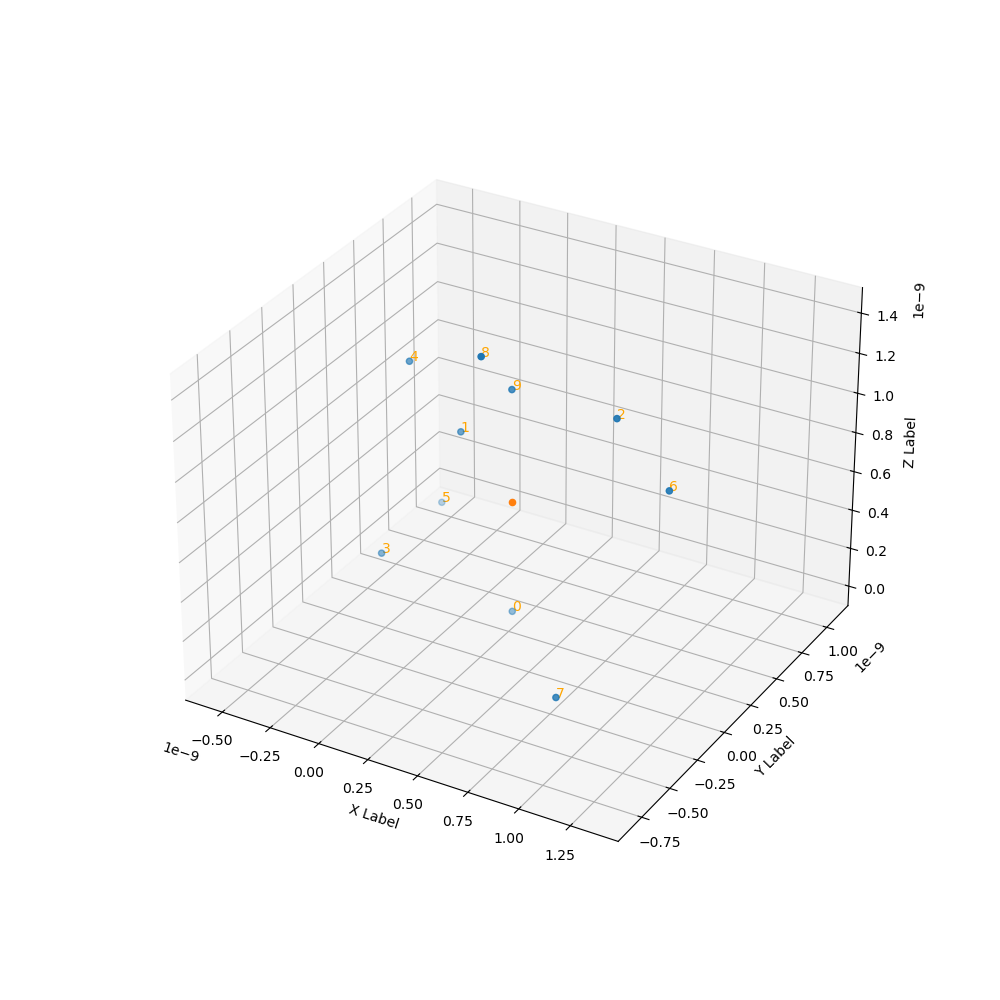

In [17]:
%matplotlib widget

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]




ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.scatter(0.5*a, 0.5*a, 0.5*c)


for i in range(len(positions)):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="orange")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

pass

In [18]:
a_par_data[permutation]

array([   nan, -6410.,  -950.,   880.,  2230., 22210.,  4460.,   240.,
        2230.,  -610.])

In [19]:
coord_to_index((0,0,1,0), max_distance, site_nb)

2224

In [20]:
max_distance

10

In [21]:
e = compute_a_par((0,0,0,0))
e

22568.72975796195